In [1]:
import pandas as pd
import numpy as np
import re
from collections import Counter
from konlpy.tag import Okt
from pykrx import stock
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
greed_word = ['매수','사','사다','사라','사면','사고','줍다','들어오다','들어가다','타다','수급','매집','올라타다' # 주식 구매 단어
              ,'탑승','불나방','담다','추매','추미애','영차'
              ,'오르다','올라가다','올리다','올려주다','올린다','오름','올려놓다','오른','상향' # 주식 가격 상승 단어
              ,'양봉','상방','상승','살아나다','양전','상한','반등','폭등','퍽등','급등'
              ,'탐욕','찬티','좋다','간다','가다','가즈','싸다','익절','제발','최고','돌파','수익','위대하다','먹다' # 탐욕 단어
              ,'기회','바닥','호재','버티다','존버','감사','감사하다','대박','대단하다','승리','찬양','믿다','흑우'
              ,'개꿀','회복','갓','홀딩','부활']

fear_word = ['공매도','공매','매도','팔','파다','팔다','팔고','팔면','던지다','털다','탈출','튀다','튀어','설거지' # 주식 판매 단어
             ,'손절','버리다'
             ,'떨어지다','떨구다','빠지다','하락','폭락','떡락','조정','급락','음봉','하방','폭포수','음전' # 주식 가격 하락 단어
             ,'반토막','내리다','내려오다','깨지다','대퍽락','나락','붕괴','추락'
             ,'공포','안티','망하다','물리다','끝나다','손해','폭망','거품','무섭다','자살','악재','상폐','개미지옥' # 공포 단어
             ,'시발','염병','욕','짜증나다','걸레','어휴','개','놈','아가리','빡치다','지랄','손실'
             ,'개관','주가조작','쓰레기','죽다','패닉']

In [3]:
df = pd.read_csv('./src/네이버종토방댓글_카카오_7500.csv')
df = df[df['댓글'] != 'error'] # 크롤링 에러 제거
df = df.dropna() # 결측치 제거
df

,날짜,댓글,조회수,좋아요,싫어요
0,2022-04-29,오늘은 아쉽지만 종가 예상 9만-9만1천...,7,0,0
1,2022-04-29,카카오 방이에요 ~!,9,0,0
2,2022-04-29,하방 경직성,21,1,1
3,2022-04-29,15만간다고 입방정떨때부터 알아봤다..,17,1,0
4,2022-04-29,역시 개 지 랄은 개카오..,32,2,0
...,...,...,...,...,...
149995,2021-02-10,"저 이제 시작한 주린이 인데,,,",898,2,0
149996,2021-02-10,답글:[삭제된 게시물의 답글]나는 익절한다,157,0,0
149997,2021-02-10,카카오도 공매가 있을것인데,228,1,0
149998,2021-02-10,카카오 목표가 585천원 써놓고,297,3,0


In [4]:
df['한글댓글'] = df['댓글'].str.replace('\[삭제된 게시물의 답글\]',' ')
df['한글댓글'] = df['한글댓글'].str.replace('답글:',' ')
df['한글댓글'] = df['한글댓글'].str.replace('[^가-힣]',' ').str.replace(' +',' ').str.strip()
df = df[df['한글댓글'] != '']
df = df.reset_index(drop=True)
df

,날짜,댓글,조회수,좋아요,싫어요,한글댓글
0,2022-04-29,오늘은 아쉽지만 종가 예상 9만-9만1천...,7,0,0,오늘은 아쉽지만 종가 예상 만 만 천
1,2022-04-29,카카오 방이에요 ~!,9,0,0,카카오 방이에요
2,2022-04-29,하방 경직성,21,1,1,하방 경직성
3,2022-04-29,15만간다고 입방정떨때부터 알아봤다..,17,1,0,만간다고 입방정떨때부터 알아봤다
4,2022-04-29,역시 개 지 랄은 개카오..,32,2,0,역시 개 지 랄은 개카오
...,...,...,...,...,...,...
147840,2021-02-10,"저 이제 시작한 주린이 인데,,,",898,2,0,저 이제 시작한 주린이 인데
147841,2021-02-10,답글:[삭제된 게시물의 답글]나는 익절한다,157,0,0,나는 익절한다
147842,2021-02-10,카카오도 공매가 있을것인데,228,1,0,카카오도 공매가 있을것인데
147843,2021-02-10,카카오 목표가 585천원 써놓고,297,3,0,카카오 목표가 천원 써놓고


In [5]:
okt = Okt()

greed_list = []
fear_list = []
for i in range(df.shape[0]):
    comment = df['한글댓글'][i]
    word = okt.morphs(comment, stem=True)
    word_dict = dict(Counter(word))
    
    greed_cnt = 0
    for j in greed_word:
        try:
            greed_cnt += word_dict[j]
        except:
            pass
    greed_list.append(greed_cnt)
        
    fear_cnt = 0
    for k in fear_word:
        try:
            fear_cnt += word_dict[k]
        except:
            pass
    fear_list.append(fear_cnt)
    
    if i % 10000 == 0:
        print(f'현재{i}개 필터링 완료')   

현재0개 필터링 완료
현재10000개 필터링 완료
현재20000개 필터링 완료
현재30000개 필터링 완료
현재40000개 필터링 완료
현재50000개 필터링 완료
현재60000개 필터링 완료
현재70000개 필터링 완료
현재80000개 필터링 완료
현재90000개 필터링 완료
현재100000개 필터링 완료
현재110000개 필터링 완료
현재120000개 필터링 완료
현재130000개 필터링 완료
현재140000개 필터링 완료


In [6]:
df['탐욕'] = greed_list
df['공포'] = fear_list
df

,날짜,댓글,조회수,좋아요,싫어요,한글댓글,탐욕,공포
0,2022-04-29,오늘은 아쉽지만 종가 예상 9만-9만1천...,7,0,0,오늘은 아쉽지만 종가 예상 만 만 천,0,0
1,2022-04-29,카카오 방이에요 ~!,9,0,0,카카오 방이에요,0,0
2,2022-04-29,하방 경직성,21,1,1,하방 경직성,0,1
3,2022-04-29,15만간다고 입방정떨때부터 알아봤다..,17,1,0,만간다고 입방정떨때부터 알아봤다,1,0
4,2022-04-29,역시 개 지 랄은 개카오..,32,2,0,역시 개 지 랄은 개카오,0,2
...,...,...,...,...,...,...,...,...
147840,2021-02-10,"저 이제 시작한 주린이 인데,,,",898,2,0,저 이제 시작한 주린이 인데,0,0
147841,2021-02-10,답글:[삭제된 게시물의 답글]나는 익절한다,157,0,0,나는 익절한다,1,0
147842,2021-02-10,카카오도 공매가 있을것인데,228,1,0,카카오도 공매가 있을것인데,0,1
147843,2021-02-10,카카오 목표가 585천원 써놓고,297,3,0,카카오 목표가 천원 써놓고,0,0


In [7]:
day_df = pd.DataFrame()
day_df[['날짜','댓글 수']] = df.groupby('날짜').count().reset_index()[['날짜','댓글']]
day_df['조회수 합계'] = df.groupby('날짜').sum().reset_index()['조회수']
day_df['탐욕'] = df.groupby('날짜').sum().reset_index()['탐욕']
day_df['공포'] = df.groupby('날짜').sum().reset_index()['공포']
day_df['탐욕-공포'] = day_df['탐욕'] - day_df['공포']
day_df['날짜'] = pd.to_datetime(day_df['날짜'])
day_df = day_df.set_index('날짜')
day_df

,댓글 수,조회수 합계,탐욕,공포,탐욕-공포
날짜,,,,,
2021-02-10,111,59537,26,16,10
2021-02-11,51,37074,4,2,2
2021-02-12,41,22911,9,4,5
2021-02-13,61,27989,13,1,12
2021-02-14,55,27752,7,4,3
...,...,...,...,...,...
2022-04-25,269,60829,44,67,-23
2022-04-26,170,38031,30,32,-2
2022-04-27,349,77250,55,53,2


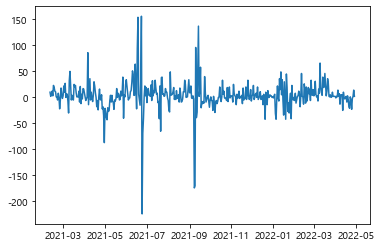

In [8]:
plt.plot(day_df['탐욕-공포'])

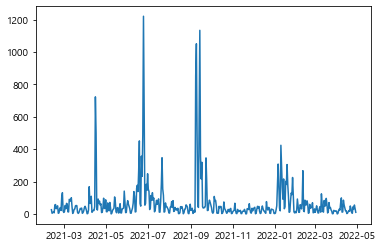

In [9]:
plt.plot(day_df['탐욕'])

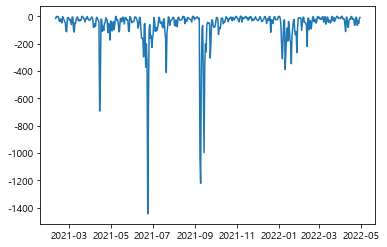

In [10]:
plt.plot(-day_df['공포'])

In [11]:
pykrx_df = stock.get_market_ohlcv_by_date(fromdate='2021-02-15', todate='2022-04-28', ticker="035720", adjusted=False)
pykrx_df

,시가,고가,저가,종가,거래량,거래대금,등락률
날짜,,,,,,,
2021-02-15,499000,505000,492000,502000,1052548,525405008000,2.55
2021-02-16,504000,519000,499500,514000,1076048,547462467000,2.39
2021-02-17,515000,515000,503000,509000,562572,285858658000,-0.97
2021-02-18,506000,517000,501000,501000,466922,236538803000,-1.57
2021-02-19,497000,506000,490000,504000,695664,345815290000,0.60
...,...,...,...,...,...,...,...
2022-04-22,92200,92400,91400,92000,1553904,142543689400,-1.71
2022-04-25,90400,91600,89600,89700,1511408,136367837200,-2.50
2022-04-26,89800,91700,89700,90200,1368258,123958023400,0.56


In [12]:
df2 = pykrx_df[['종가','등락률']].join(day_df).reset_index()
df2

,날짜,종가,등락률,댓글 수,조회수 합계,탐욕,공포,탐욕-공포
0,2021-02-15,502000,2.55,258,145269,55,32,23
1,2021-02-16,514000,2.39,259,132139,58,39,19
2,2021-02-17,509000,-0.97,119,64312,32,20,12
3,2021-02-18,501000,-1.57,187,84844,42,31,11
4,2021-02-19,504000,0.60,207,96353,50,49,1
...,...,...,...,...,...,...,...,...
294,2022-04-22,92000,-1.71,242,54344,33,54,-21
295,2022-04-25,89700,-2.50,269,60829,44,67,-23
296,2022-04-26,90200,0.56,170,38031,30,32,-2
297,2022-04-27,88400,-2.00,349,77250,55,53,2


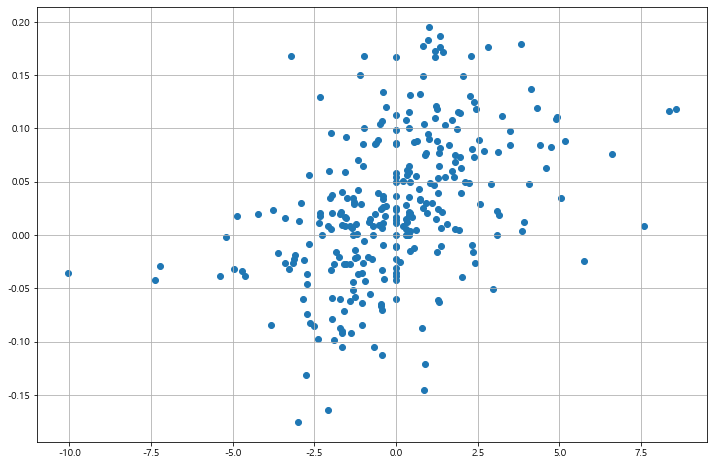

In [15]:
plt.figure(figsize=(12,8))

x = df2['등락률']
y = df2['탐욕-공포']/df2['댓글 수']

plt.scatter(x, y)
plt.grid()
plt.show()

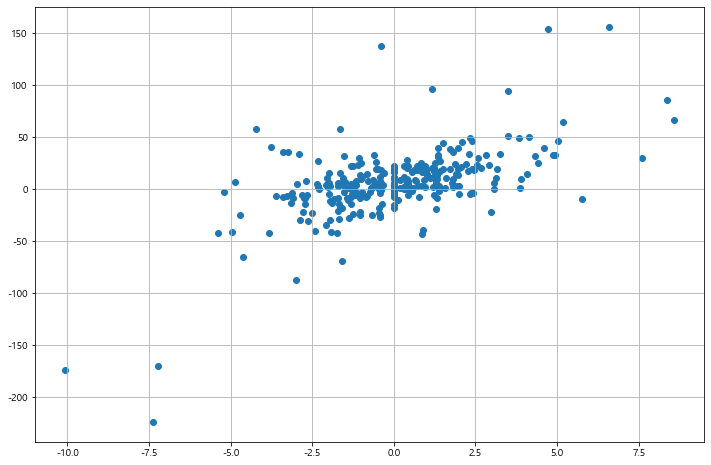

In [16]:
plt.figure(figsize=(12,8))

x = df2['등락률']
y = df2['탐욕-공포']

plt.scatter(x, y)
plt.grid()
plt.show()